# Flavour Classification

Chemical language Model : Molformer

Classification using:
- Tree based models
- LoRA Fine Tuning
- Full Fine tuning

---

In [8]:
pip install -q imbalanced-learn


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install -q xgboost

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


### Load Molformer Model

In [ ]:
import torch  
import numpy as np
import pandas as pd
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
from transformers import AutoModel, AutoTokenizer

model_mol = AutoModel.from_pretrained("ibm/MoLFormer-XL-both-10pct", deterministic_eval=True, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mol.to(device)

MolformerModel(
  (embeddings): MolformerEmbeddings(
    (word_embeddings): Embedding(2362, 768, padding_idx=2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder): MolformerEncoder(
    (layer): ModuleList(
      (0-11): 12 x MolformerLayer(
        (attention): MolformerAttention(
          (self): MolformerSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (rotary_embeddings): MolformerRotaryEmbedding()
            (feature_map): MolformerFeatureMap(
              (kernel): ReLU()
            )
          )
          (output): MolformerSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (in

### Loading Datasets

In [4]:
print(model_mol.device)

cuda:0


In [4]:
import pandas as pd

train_flav=pd.read_csv('./fart_train.csv')
val_flav=pd.read_csv('./fart_val.csv')
test_flav=pd.read_csv('./fart_test.csv')

In [6]:
train_flav.head()

,Unnamed: 0,Canonicalized SMILES,Standardized SMILES,Canonicalized Taste,Original Labels,Source,is_multiclass
0,0,COC(=O)c1cccc(CCc2ccc(OC)c(O)c2)c1,COC(=O)c1cccc(CCc2ccc(OC)c(O)c2)c1,undefined,"Tasteless, Tastelessness",chemtastes_db,0
1,1,CCCCCC(=Cc1ccccc1)COC(=O)CC(C)C,CCCCCC(=Cc1ccccc1)COC(=O)CC(C)C,undefined,"oily, tobacco, fruity",flavor_db,0
2,2,CC=C(C)C(CCC(C)CCCC(C)C(C)CCC(C)C)OC1C(CO)OC(O...,CC=C(C)C(CCC(C)CCCC(C)C(C)CCC(C)C)OC1C(CO)OC(O...,sweet,sweet-like,flavor_db,0
3,3,CCC(C)C(N)C(=O)NC(Cc1ccccc1)C(=O)NC(CC(=O)O)C(...,CCC(C)C(N)C(=O)NC(Cc1ccccc1)C(=O)NC(CC(=O)O)C(...,sweet,sweet,flavor_db,0
4,4,CCOC1OC(CO)C(O)C(OC2OC(CO)C(O)C(O)C2O)C1O,CCOC1OC(CO)C(O)C(OC2OC(CO)C(O)C(O)C2O)C1O,sweet,sweet-like,flavor_db,0


### Class Distribution

In [12]:
counts=train_flav['Canonicalized Taste'].value_counts()

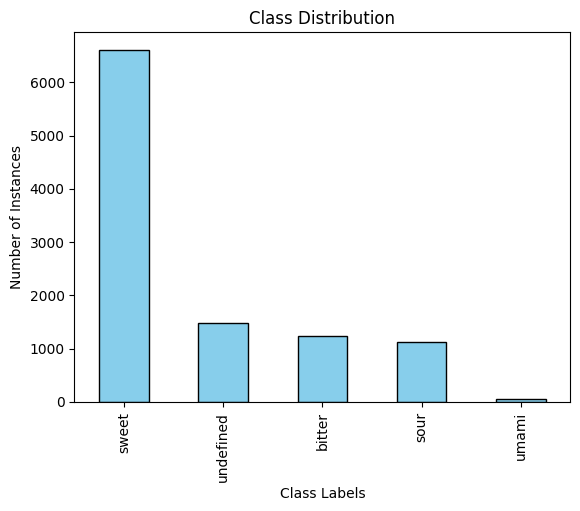

In [13]:
import matplotlib.pyplot as plt

counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel("Class Labels")
plt.ylabel("Number of Instances")
plt.title("Class Distribution")
plt.show()


In [7]:
train_flav.shape

(10517, 7)

### Generating Embeddings

In [5]:
def get_embed(data):
   

    my_input=[]
    embeddings=[]
    for i in data:


    #smiles_embedding=tokenizer(i, padding=True, return_tensors="pt")
        tokenized = tokenizer(i, padding=True, return_tensors="pt").to(device)  # Move to GPU
        my_input.append(tokenized)

    # Iterate through the tokenized SMILES data and process in batches
    for tokenized_input in my_input:
        with torch.no_grad():
            # Pass the tokenized input to the model
            output = model_mol(**tokenized_input)
            # Extract the pooler output
            embedding = output.pooler_output
            # Append to the embeddings list
            embeddings.append(embedding.cpu())


    embeddings_tensor = torch.cat(embeddings, dim=0)
    embeddings_tensor_num=embeddings_tensor.numpy()

    return embeddings_tensor_num




In [6]:
# Extract SMILES sequences and labels
train_smiles, train_labels = train_flav["Canonicalized SMILES"], train_flav["Canonicalized Taste"]
val_smiles, val_labels = val_flav["Canonicalized SMILES"], val_flav["Canonicalized Taste"]
test_smiles, test_labels = test_flav["Canonicalized SMILES"], test_flav["Canonicalized Taste"]

#Convert labels to numeric using LabelEncoder
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)
test_labels = label_encoder.transform(test_labels)

#Get ChemBERTa embeddings
train_embeddings = get_embed(train_smiles.tolist())
val_embeddings = get_embed(val_smiles.tolist())
test_embeddings = get_embed(test_smiles.tolist())


### Classification models

In [7]:
import os
os.environ["SCIPY_ARRAY_API"] = "1"


In [8]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [10]:
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, classification_report, precision_recall_fscore_support, roc_auc_score
)
from sklearn.utils.class_weight import compute_sample_weight



def return_scores(all_y_pred, all_y_true, y, title="Define Title"):

    # Get unique classes
    classes = np.unique(all_y_true)

    # Binarize the true and predicted labels for multi-class AUC calculation
    y_true_bin = label_binarize(all_y_true, classes=classes)
    y_pred_bin = label_binarize(all_y_pred, classes=classes)

    # Calculate AUC for each class using One-vs-Rest (OvR) method
  
    # Average AUC across all classes
    avg_auc = roc_auc_score(y_true_bin, y_pred_bin, average="macro", multi_class="ovr")

    # Weighted AUC, which considers the support of each class
    weighted_auc = roc_auc_score(y_true_bin, y_pred_bin, average="weighted", multi_class="ovr")


    print(f"{title}")
    # Calculate overall accuracy
    overall_accuracy = accuracy_score(all_y_true, all_y_pred)

    # Print classification report for per-class metrics
    print("\nPer-Class Classification Report:")
    print(classification_report(all_y_true, all_y_pred, target_names=np.unique(y), digits=4))

    # Calculate weighted and macro averages for precision, recall, and F1 score
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        all_y_true, all_y_pred, average='weighted'
    )

    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        all_y_true, all_y_pred, average='macro'
    )

    print(f"Overall Accuracy: {overall_accuracy:.4f}")

    # Print weighted averages
    print("\nWeighted Averages:")
    print(f"Weighted Precision: {precision_weighted:.4f}")
    print(f"Weighted Recall: {recall_weighted:.4f}")
    print(f"Weighted F1 Score: {f1_weighted:.4f}")
    print(f"Weighted Average AUC: {weighted_auc:.4f}")

    # Print unweighted (macro) averages
    print("\nMacro Averages (Unweighted):")
    print(f"Macro Precision: {precision_macro:.4f}")
    print(f"Macro Recall: {recall_macro:.4f}")
    print(f"Macro F1 Score: {f1_macro:.4f}")
    print(f"Average AUC (macro): {avg_auc:.4f}")

    # Optional: Calculate per-class precision, recall, and F1 score explicitly
    # Get per-class metrics using precision_recall_fscore_support without averaging
    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
        all_y_true, all_y_pred, average=None, labels=np.unique(all_y_true)
    )



In [11]:

# Define hyperparameter grids
xgb_param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 10, 15],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.6, 0.8, 1.0]
}

brf_param_grid = {
    'n_estimators': [50, 100, 150, 200],
    
    'max_depth': [3, 5, 10, 15]
}

# Initialize models
xgb = XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', random_state=101, tree_method='gpu_hist')
#brf = BalancedRandomForestClassifier(criterion="gini", random_state=101, sampling_strategy='all', replacement=True, bootstrap=False)

# Perform grid search with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

xgb_grid = GridSearchCV(xgb, xgb_param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
#brf_grid = GridSearchCV(brf, brf_param_grid, scoring='balanced_accuracy', cv=cv, n_jobs=-1)


sample_weights = compute_sample_weight("balanced", train_labels)

# Fit models
xgb_grid.fit(train_embeddings, train_labels, sample_weight=sample_weights)
#brf_grid.fit(train_embeddings, train_labels)

# Best models
best_xgb = xgb_grid.best_estimator_
#best_brf = brf_grid.best_estimator_

# Validation Performance
xgb_val_pred = best_xgb.predict(val_embeddings)
#brf_val_pred = best_brf.predict(val_embeddings)

xgb_acc = accuracy_score(val_labels, xgb_val_pred)
#brf_acc = balanced_accuracy_score(val_labels, brf_val_pred)

print("Best XGBoost Accuracy:", xgb_acc)
#print("Best Balanced RF Accuracy:", brf_acc)

# Test on final test set
y_xgb_pred = np.argmax(best_xgb.predict_proba(test_embeddings), axis=1)
#y_brf_pred = best_brf.predict(test_embeddings)

# Return final scores
return_scores(y_xgb_pred, test_labels, test_flav["Canonicalized Taste"].values, title="XGBoost on fingerprints")
#return_scores(y_brf_pred, test_labels, test_flav["Canonicalized Taste"].values, title="Balanced Random Forest")


/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:57:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:57:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:57:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` para

Best XGBoost Accuracy: 0.7910381543921916
XGBoost on fingerprints

Per-Class Classification Report:
              precision    recall  f1-score   support

      bitter     0.5385    0.6009    0.5680       233
        sour     0.6833    0.8613    0.7621       238
       sweet     0.9613    0.8432    0.8984      1473
       umami     0.0714    0.1667    0.1000         6
   undefined     0.6314    0.8059    0.7081       304

    accuracy                         0.8132      2254
   macro avg     0.5772    0.6556    0.6073      2254
weighted avg     0.8414    0.8132    0.8220      2254

Overall Accuracy: 0.8132

Weighted Averages:
Weighted Precision: 0.8414
Weighted Recall: 0.8132
Weighted F1 Score: 0.8220
Weighted Average AUC: 0.8752

Macro Averages (Unweighted):
Macro Precision: 0.5772
Macro Recall: 0.6556
Macro F1 Score: 0.6073
Average AUC (macro): 0.8028


/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:59:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:59:03] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


### Hyperparameter Tuning Using Optuna (Bayesian Optimisation)

In [12]:
pip install -q optuna xgboost


Note: you may need to restart the kernel to use updated packages.


In [15]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
import pandas as pd


In [ ]:
def objective(trial):
    # Suggest hyperparameters
    params = {
        'objective': 'multi:softmax',  # Multi-class classification
        'num_class': 3,  # Number of classes
        'eval_metric': 'mlogloss',  # Multi-class log loss
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0)
    }

    # Train XGBoost model
    model = xgb.XGBClassifier(**params, use_label_encoder=False, verbosity=0)
    model.fit(train_embeddings, train_labels)

    # Predict on test data
    y_pred = model.predict(val_embeddings)
    
    # Compute accuracy
    accuracy = accuracy_score(val_labels, y_pred)
    print(accuracy)
    return accuracy  # Optuna will try to maximize this


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)
print("Best F1-score:", study.best_value)

Output:

Trial 49 finished with value: 0.8793256433007985 and parameters: {'max_depth': 7, 'learning_rate': 0.029366785529286264, 'n_estimators': 285, 'subsample': 0.6678722705318085, 'colsample_bytree': 0.5447777825991827, 'gamma': 1.0170852220691309e-08, 'reg_alpha': 8.637905836952225e-05, 'reg_lambda': 1.3707289357648895}. Best is trial 13 with value: 0.8890860692102928.

Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.16946008586003722, 'n_estimators': 154, 'subsample': 0.6908516325290748, 'colsample_bytree': 0.6977048642164865, 'gamma': 3.6360127288591845e-06, 'reg_alpha': 6.549463573509468e-07, 'reg_lambda': 0.24235638328844453}

Best F1-score: 0.8890860692102928

In [21]:
def objective(trial):
    params = {
        'objective': 'multi:softmax',  # Multi-class classification
        'num_class': 3,  # Number of classes
        'eval_metric': 'mlogloss',  # Multi-class log loss
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.1, 10)  # Important for imbalance
    }
    
    # Train XGBoost model
    model = xgb.XGBClassifier(**params, use_label_encoder=False, verbosity=0)
    model.fit(train_embeddings, train_labels)

    # Predict on test data
    y_pred = model.predict(val_embeddings)
    
    # Compute accuracy
    accuracy = accuracy_score(val_labels, y_pred)
    print(accuracy)
    return accuracy  # Optuna will try to maximize this

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)
print("Best F1-score:", study.best_value)

Output: 

Trial 49 finished with value: 0.8637976929902396 and parameters: 
{'max_depth': 6, 'learning_rate': 0.02573197813363534, 'n_estimators': 81, 'subsample': 0.6524812169860011, 'colsample_bytree': 0.7398228839295856, 'gamma': 4.373689850015363e-07, 'reg_alpha': 0.33601065678457753, 'scale_pos_weight': 7.0680530628239495}. Best is trial 44 with value: 0.8930789707187222.
0.8637976929902396

Best hyperparameters: {'max_depth': 5, 'learning_rate': 0.2500859518097839, 'n_estimators': 179, 'subsample': 0.7487190494681261, 'colsample_bytree': 0.7495632771897014, 'gamma': 0.3200208210000502, 'reg_alpha': 0.0018045499088806866, 'scale_pos_weight': 4.563226920489004}

Best F1-score: 0.8930789707187222

In [19]:

# ✅ Train the final model using the best hyperparameters
best_model = xgb.XGBClassifier(**study.best_params, use_label_encoder=False, verbosity=0)
best_model.fit(train_embeddings, train_labels)

# ✅ Make predictions on the test set
test_preds = best_model.predict(test_embeddings)

# ✅ Compute accuracy and classification report on test set
test_accuracy = accuracy_score(test_labels, test_preds)
print("\nFinal Accuracy on Test Set:", test_accuracy)

print("\nClassification Report on Test Set:")
print(classification_report(test_labels, test_preds))


Final Accuracy on Test Set: 0.8779946761313221

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.81      0.66      0.73       233
           1       0.89      0.89      0.89       238
           2       0.93      0.94      0.93      1473
           3       1.00      0.17      0.29         6
           4       0.68      0.75      0.71       304

    accuracy                           0.88      2254
   macro avg       0.86      0.68      0.71      2254
weighted avg       0.88      0.88      0.88      2254



In [23]:

# ✅ Train the final model using the best hyperparameters
best_model = xgb.XGBClassifier(**study.best_params, use_label_encoder=False, verbosity=0)
best_model.fit(train_embeddings, train_labels)

# ✅ Make predictions on the test set
test_preds = best_model.predict(test_embeddings)

# ✅ Compute accuracy and classification report on test set
test_accuracy = accuracy_score(test_labels, test_preds)
print("\nFinal Accuracy on Test Set:", test_accuracy)

print("\nClassification Report on Test Set:")
print(classification_report(test_labels, test_preds))


Final Accuracy on Test Set: 0.883318544809228

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.81      0.67      0.73       233
           1       0.89      0.89      0.89       238
           2       0.93      0.94      0.94      1473
           3       1.00      0.17      0.29         6
           4       0.71      0.76      0.73       304

    accuracy                           0.88      2254
   macro avg       0.87      0.69      0.72      2254
weighted avg       0.88      0.88      0.88      2254



## LoRA Finetuning on Molformer
(Focal Loss to handle imbalance)

### Dataset Loading

In [1]:
#libararies
import evaluate
from scipy.special import softmax
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score,matthews_corrcoef
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import Dataset
from datasets import load_dataset
import datasets
from peft import LoraConfig, get_peft_model
import torch
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from transformers import Trainer
from transformers import TrainingArguments
import pandas as pd
import numpy as np

/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_flav=pd.read_csv('./fart_train.csv')
train_flav.reset_index(drop=True, inplace=True)
val_flav=pd.read_csv('./fart_val.csv')
val_flav.reset_index(drop=True, inplace=True)
test_flav=pd.read_csv('./fart_test.csv')
test_flav.reset_index(drop=True, inplace=True)

In [33]:
train_flav.head()

,Unnamed: 0,Canonicalized SMILES,Standardized SMILES,Canonicalized Taste,Original Labels,Source,is_multiclass
0,0,COC(=O)c1cccc(CCc2ccc(OC)c(O)c2)c1,COC(=O)c1cccc(CCc2ccc(OC)c(O)c2)c1,undefined,"Tasteless, Tastelessness",chemtastes_db,0
1,1,CCCCCC(=Cc1ccccc1)COC(=O)CC(C)C,CCCCCC(=Cc1ccccc1)COC(=O)CC(C)C,undefined,"oily, tobacco, fruity",flavor_db,0
2,2,CC=C(C)C(CCC(C)CCCC(C)C(C)CCC(C)C)OC1C(CO)OC(O...,CC=C(C)C(CCC(C)CCCC(C)C(C)CCC(C)C)OC1C(CO)OC(O...,sweet,sweet-like,flavor_db,0
3,3,CCC(C)C(N)C(=O)NC(Cc1ccccc1)C(=O)NC(CC(=O)O)C(...,CCC(C)C(N)C(=O)NC(Cc1ccccc1)C(=O)NC(CC(=O)O)C(...,sweet,sweet,flavor_db,0
4,4,CCOC1OC(CO)C(O)C(OC2OC(CO)C(O)C(O)C2O)C1O,CCOC1OC(CO)C(O)C(OC2OC(CO)C(O)C(O)C2O)C1O,sweet,sweet-like,flavor_db,0


In [3]:
train_flav.drop('Unnamed: 0',axis=1, inplace=True)
val_flav.drop('Unnamed: 0',axis=1, inplace=True)
test_flav.drop('Unnamed: 0',axis=1, inplace=True)

In [36]:
train_flav

,Canonicalized SMILES,Standardized SMILES,Canonicalized Taste,Original Labels,Source,is_multiclass
0,COC(=O)c1cccc(CCc2ccc(OC)c(O)c2)c1,COC(=O)c1cccc(CCc2ccc(OC)c(O)c2)c1,undefined,"Tasteless, Tastelessness",chemtastes_db,0
1,CCCCCC(=Cc1ccccc1)COC(=O)CC(C)C,CCCCCC(=Cc1ccccc1)COC(=O)CC(C)C,undefined,"oily, tobacco, fruity",flavor_db,0
2,CC=C(C)C(CCC(C)CCCC(C)C(C)CCC(C)C)OC1C(CO)OC(O...,CC=C(C)C(CCC(C)CCCC(C)C(C)CCC(C)C)OC1C(CO)OC(O...,sweet,sweet-like,flavor_db,0
3,CCC(C)C(N)C(=O)NC(Cc1ccccc1)C(=O)NC(CC(=O)O)C(...,CCC(C)C(N)C(=O)NC(Cc1ccccc1)C(=O)NC(CC(=O)O)C(...,sweet,sweet,flavor_db,0
4,CCOC1OC(CO)C(O)C(OC2OC(CO)C(O)C(O)C2O)C1O,CCOC1OC(CO)C(O)C(OC2OC(CO)C(O)C(O)C2O)C1O,sweet,sweet-like,flavor_db,0
...,...,...,...,...,...,...
10512,ON=CC1=CCCCCC1,ON=CC1=CCCCCC1,bitter,"Sweet/Bitter, Multitaste",chemtastes_db,1
10513,ON=CC1CCCCC1,ON=CC1CCCCC1,bitter,"Bitter, Bitterness",chemtastes_db,1
10514,ON=CC1CCCCC1,ON=CC1CCCCC1,sweet,"Bitter, Bitterness",chemtastes_db,1
10515,Sc1ccccc1,Sc1ccccc1,undefined,"garlic, penetrating, repulsive",flavor_db,1


In [4]:

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "ibm/MoLFormer-XL-both-10pct",
    trust_remote_code=True
)

# Load the model with a classification head
model = AutoModelForSequenceClassification.from_pretrained(
    "ibm/MoLFormer-XL-both-10pct",
    num_labels=5,
    trust_remote_code=True
)

Some weights of MolformerForSequenceClassification were not initialized from the model checkpoint at ibm/MoLFormer-XL-both-10pct and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.dense2.bias', 'classifier.dense2.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Preparing the dataset

In [5]:
train_dataset = Dataset.from_pandas(train_flav)
val_dataset = Dataset.from_pandas(val_flav)
test_dataset = Dataset.from_pandas(test_flav)

In [6]:
def tokenize_function(examples):

    return tokenizer(examples["Canonicalized SMILES"], padding="max_length", truncation=True, max_length=512)


train_dataset = train_dataset.map(tokenize_function, batched=True)

val_dataset = val_dataset.map(tokenize_function, batched=True)

test_dataset = test_dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 2254/2254 [00:00<00:00, 3986.02 examples/s]


In [52]:
train_dataset

Dataset({
    features: ['Canonicalized SMILES', 'Standardized SMILES', 'Canonicalized Taste', 'Original Labels', 'Source', 'is_multiclass', 'input_ids', 'attention_mask'],
    num_rows: 10517
})

In [7]:
label_encoder = LabelEncoder() 

In [8]:

# Label encoding

encoded_labels = label_encoder.fit_transform(train_dataset['Canonicalized Taste'])

train_dataset = train_dataset.add_column('label', encoded_labels)

encoded_labels = label_encoder.fit_transform(val_dataset['Canonicalized Taste'])

val_dataset = val_dataset.add_column('label', encoded_labels)

encoded_labels = label_encoder.fit_transform(test_dataset['Canonicalized Taste'])

test_dataset = test_dataset.add_column('label', encoded_labels) 

In [54]:
train_dataset

Dataset({
    features: ['Canonicalized SMILES', 'Standardized SMILES', 'Canonicalized Taste', 'Original Labels', 'Source', 'is_multiclass', 'input_ids', 'attention_mask', 'label'],
    num_rows: 10517
})

In [55]:
val_dataset

Dataset({
    features: ['Canonicalized SMILES', 'Standardized SMILES', 'Canonicalized Taste', 'Original Labels', 'Source', 'is_multiclass', 'input_ids', 'attention_mask', 'label'],
    num_rows: 2254
})

In [9]:
columns_to_remove = ["Canonicalized SMILES", "Standardized SMILES", 
                     "Canonicalized Taste", "Original Labels", "Source", "is_multiclass"]

# Remove columns from all datasets
train_dataset = train_dataset.remove_columns(columns_to_remove)
val_dataset = val_dataset.remove_columns(columns_to_remove)
test_dataset = test_dataset.remove_columns(columns_to_remove)


In [19]:
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'label'],
    num_rows: 10517
})

In [17]:
test_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'label'],
    num_rows: 2254
})

### Defining Compute Metrics

In [23]:

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):

    logits, labels = eval_pred

    predictions = np.argmax(logits, axis=-1)
    probabilities= softmax(logits, axis=1)
    mcc = matthews_corrcoef(labels, predictions)

        
    return {
            "eval_mcc_metric": mcc,
            "Accuracy": metric.compute(predictions=predictions, references=labels)["accuracy"],
            "AUC-ROC": roc_auc_score(labels, probabilities,multi_class="ovr"),  # AUC-ROC requires probabilities
            "Precision": precision_score(labels, predictions,average="macro"),
            "Recall": recall_score(labels, predictions,average="macro"),
            "F1-score": f1_score(labels, predictions,average="macro")
        }

### Define LoRA Config

In [11]:

lora_config = LoraConfig(
    task_type="SEQ_CLS",  # Sequence classification task
    r=8,  # Rank of LoRA matrices
    lora_alpha=16,  # Scaling factor double of rank( from the rule of thumb)
    target_modules='all-linear',
    lora_dropout=0.1,  
    #init_lora_weights="gaussian"
)

model = get_peft_model(model, lora_config)

### Changing target modules

In [11]:
lora_config_2 = LoraConfig(
    task_type="SEQ_CLS",  # Sequence classification task
    r=8,  # Rank of LoRA matrices
    lora_alpha=16,  # Scaling factor double of rank( from the rule of thumb)
    target_modules = [
    "attention.self.query",
    "attention.self.key",
    "attention.self.value",
    "attention.output.dense",
    "intermediate.dense",
    "output.dense",
    "classifier.dense",
    "classifier.dense2",
    "classifier.out_proj"
],
    lora_dropout=0.1,  
    #init_lora_weights="gaussian"
)

model = get_peft_model(model, lora_config_2)

### Define Custom Trainer

In [21]:
#focal loss computation

def focal_loss_multiclass(inputs, targets, alpha=1, gamma=2):
    log_prob = F.log_softmax(inputs, dim=-1)
    prob = torch.exp(log_prob)  # Convert log probabilities back to normal probabilities

    targets_one_hot = F.one_hot(targets, num_classes=inputs.shape[-1])
    pt = torch.sum(prob * targets_one_hot, dim=-1)  # Get probability of the true class

    focal_loss = -alpha * (1 - pt) ** gamma * torch.sum(log_prob * targets_one_hot, dim=-1)
    
    return focal_loss.mean() 


In [22]:


class CustomTrainer(Trainer):
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss = focal_loss_multiclass(logits, labels)
        
        return (loss, outputs) if return_outputs else loss 

### Define Training Arguments and rainer

In [ ]:

training_args = TrainingArguments(
    output_dir="./results_flavor_lora_trainer",
    evaluation_strategy="steps",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_strategy="steps",
    logging_dir="./logs_flavor_trainer",
    logging_strategy="steps",
    logging_steps=100,
    save_total_limit=10,
    remove_unused_columns=False,
    metric_for_best_model='eval_mcc_metric',
    greater_is_better=True,  
    load_best_model_at_end=True,
    
  
         
)

/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
trainer = CustomTrainer(

    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [17]:
trainer.train()
trainer.save_model('./flavor_lora_focal_TM')

Step,Training Loss,Validation Loss,Mcc Metric,Accuracy,Auc-roc,Precision,Recall,F1-score
100,0.595100,0.371835,0.378553,0.724046,0.797500,0.439295,0.341817,0.355365
200,0.386000,0.301897,0.562666,0.783940,0.842251,0.554626,0.493419,0.502533
300,0.340000,0.274731,0.605109,0.801686,0.866824,0.579206,0.525294,0.532241
400,0.321300,0.257918,0.640560,0.818545,0.885827,0.602836,0.551716,0.560421
500,0.317400,0.250580,0.640904,0.819876,0.898495,0.599368,0.552840,0.566611
600,0.305300,0.243643,0.648828,0.821650,0.900481,0.590073,0.561674,0.566803
700,0.303600,0.239017,0.657163,0.826087,0.914490,0.606984,0.566401,0.575051
800,0.294900,0.238802,0.652606,0.823869,0.909897,0.596595,0.560808,0.568871


/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [81]:
trainer.train()
trainer.save_model('./flavor_lora_focal')

Step,Training Loss,Validation Loss,Mcc Metric,Accuracy,Auc-roc,Precision,Recall,F1-score
100,0.270100,0.216106,0.694544,0.843390,0.917576,0.615550,0.597415,0.602985
200,0.281500,0.210783,0.698608,0.845164,0.921625,0.619366,0.601271,0.606197
300,0.269200,0.207709,0.700709,0.846051,0.932440,0.626482,0.601201,0.607851
400,0.264500,0.203847,0.705009,0.848270,0.932485,0.629625,0.605706,0.611746
500,0.271000,0.203531,0.707543,0.850932,0.933924,0.631181,0.603267,0.612033
600,0.264800,0.202637,0.713518,0.853594,0.938356,0.631087,0.608860,0.616655
700,0.265400,0.198457,0.711854,0.853150,0.942091,0.635256,0.606188,0.615980
800,0.255200,0.201249,0.698658,0.846051,0.941589,0.624142,0.599693,0.607749


/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### Without Focal Loss

In [ ]:

trainer = Trainer(

    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
   
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [16]:
test_eval = trainer.evaluate()
print("Available metrics:", test_eval.keys())

Available metrics: dict_keys([])


In [22]:
trainer.train()
trainer.save_model('./flavor_lora')

/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Mcc Metric,Accuracy,Auc-roc,Precision,Recall,F1-score
100,0.678600,0.579770,0.589209,0.796362,0.838687,0.579268,0.512165,0.521977
200,0.654600,0.550190,0.633725,0.813221,0.869642,0.586882,0.552756,0.555827
300,0.622400,0.531460,0.650603,0.821207,0.874614,0.606675,0.565947,0.569427
400,0.604400,0.514478,0.666755,0.829636,0.878944,0.618854,0.575862,0.579534
500,0.612000,0.504815,0.652053,0.823869,0.889538,0.603162,0.563660,0.572040
600,0.594800,0.500764,0.660623,0.826974,0.888770,0.602844,0.571263,0.576065
700,0.598600,0.497481,0.665018,0.829193,0.902541,0.614111,0.574982,0.580074
800,0.573000,0.494564,0.665194,0.829193,0.900277,0.611106,0.574884,0.579801


/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raghvendra2/micromamba/envs/Molforme

### Manual training with defined config

In [41]:
config = {
    "dropout": 0.1,
    "lora_alpha": 64,
    "lr": 0.0009824678485192827,
    "optimizer": "adamw",
    "r": 8
}


In [45]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results_manual_run_molflav_reepoch",
    evaluation_strategy="steps",
    learning_rate=config["lr"],
    per_device_train_batch_size=32,  # Keep same batch size
    per_device_eval_batch_size=32,
    num_train_epochs=20,  # Train for more epochs if needed
    weight_decay=0.01,
    save_strategy="steps",
    logging_dir="./logs_manual_run",
    logging_strategy="steps",
    logging_steps=100,  
    save_on_each_node=True,
    save_total_limit=None,
    load_best_model_at_end=True,
    metric_for_best_model="eval_mcc_metric",
    greater_is_better=True,
    remove_unused_columns=False,
)


/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [46]:
from transformers import AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model

base_model = AutoModelForSequenceClassification.from_pretrained("ibm/MoLFormer-XL-both-10pct",
    num_labels=5,
    trust_remote_code=True)

# Apply LoRA adaptation
lora_config = LoraConfig(
    r=config["r"], 
    lora_alpha=config["lora_alpha"], 
    target_modules='all-linear',
    lora_dropout=config["dropout"],
    task_type="SEQ_CLS"  # Adjust based on your task (sequence classification here)
)
model = get_peft_model(base_model, lora_config)


Some weights of MolformerForSequenceClassification were not initialized from the model checkpoint at ibm/MoLFormer-XL-both-10pct and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.dense2.bias', 'classifier.dense2.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.print_trainable_parameters()

In [47]:
from transformers import TrainerCallback
import os
import shutil

class SavePeftModelCallback(TrainerCallback):
    """Custom callback to save PEFT adapter weights correctly."""
    
    def on_save(self, args, state, control, **kwargs):
        peft_model_path = os.path.join(args.output_dir, f"checkpoint-{state.global_step}")
        
        if os.path.exists(peft_model_path):
            # Save adapter model
            kwargs["model"].save_pretrained(peft_model_path)
            print(f"✅ PEFT model saved at {peft_model_path}")


In [49]:
from transformers import Trainer

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[SavePeftModelCallback()]
)

trainer.train()
trainer.save_model('./manual_train_config_reepoch_mol')


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Mcc Metric,Accuracy,Auc-roc,Precision,Recall,F1-score
100,0.321100,0.197839,0.689040,0.836735,0.952308,0.705705,0.745007,0.722393
200,0.219500,0.142980,0.753150,0.873114,0.970602,0.766596,0.768202,0.759768
300,0.192800,0.180881,0.737981,0.860248,0.963195,0.742813,0.839666,0.780686
400,0.183200,0.127786,0.762493,0.877995,0.973112,0.734171,0.838547,0.756490
500,0.160200,0.128386,0.762809,0.877551,0.974447,0.748169,0.845416,0.772328
600,0.137900,0.117120,0.800573,0.897072,0.978405,0.829925,0.874238,0.848015
700,0.127700,0.122886,0.790829,0.889530,0.977830,0.822284,0.879699,0.846819
800,0.113300,0.127665,0.777406,0.886868,0.978815,0.777513,0.847142,0.793923
900,0.106800,0.143073,0.771240,0.880657,0.972915,0.697617,0.863242,0.716822
1000,0.098100,0.125318,0.794733,0.891304,0.974907,0.730853,0.879461,0.767002


/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 9b0846b9-3e88-4dcb-9361-2dcd2573a73d)') - silently ignoring the lookup for the file config.json in ibm/MoLFormer-XL-both-10pct.
  warnings.warn(
/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in ibm/MoLFormer-XL-both-10pct - will assume that the vocabulary was not modified.
  warnings.warn(


✅ PEFT model saved at ./results_manual_run_molflav_reepoch/checkpoint-500
✅ PEFT model saved at ./results_manual_run_molflav_reepoch/checkpoint-1000
✅ PEFT model saved at ./results_manual_run_molflav_reepoch/checkpoint-1500
✅ PEFT model saved at ./results_manual_run_molflav_reepoch/checkpoint-1660


### Evaluation on Test Dataset

In [31]:
from scipy.special import softmax
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
#load model

base_model = AutoModelForSequenceClassification.from_pretrained(
    "ibm/MoLFormer-XL-both-10pct",
    num_labels=5,
    problem_type="single_label_classification",    
    trust_remote_code=True,
    deterministic_eval=True
)




Some weights of MolformerForSequenceClassification were not initialized from the model checkpoint at ibm/MoLFormer-XL-both-10pct and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.dense2.bias', 'classifier.dense2.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### manual config model

In [38]:
from peft import PeftModel

adapter_model = PeftModel.from_pretrained(base_model, "/home/raghvendra2/Molformer_Finetuning/results_manual_run/checkpoint-830")

/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/peft/peft_model.py:599: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.classifier.original_module.dense.lora_A.default.weight', 'base_model.model.classifier.original_module.dense.lora_B.default.weight', 'base_model.model.classifier.original_module.dense2.lora_A.default.weight', 'base_model.model.classifier.original_module.dense2.lora_B.default.weight', 'base_model.model.classifier.original_module.out_proj.lora_A.default.weight', 'base_model.model.classifier.original_module.out_proj.lora_B.default.weight', 'base_model.model.classifier.dense.lora_A.default.weight', 'base_model.model.classifier.dense.lora_B.default.weight', 'base_model.model.classifier.dense2.lora_A.default.weight', 'base_model.model.classifier.dense2.lora_B.default.weight', 'base_model.model.classifier.out_proj.lora_A.default.weight', 'base_model.model.classifier.out_proj.lora_B.default.weight']
  warnings.w

In [29]:
from peft import PeftModel

adapter_model = PeftModel.from_pretrained(base_model, "/home/raghvendra2/Molformer_Finetuning/results_flavor_lora_trainer/checkpoint-825")

/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/peft/peft_model.py:599: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.classifier.original_module.dense.lora_A.default.weight', 'base_model.model.classifier.original_module.dense.lora_B.default.weight', 'base_model.model.classifier.original_module.dense2.lora_A.default.weight', 'base_model.model.classifier.original_module.dense2.lora_B.default.weight', 'base_model.model.classifier.original_module.out_proj.lora_A.default.weight', 'base_model.model.classifier.original_module.out_proj.lora_B.default.weight', 'base_model.model.classifier.dense.lora_A.default.weight', 'base_model.model.classifier.dense.lora_B.default.weight', 'base_model.model.classifier.dense2.lora_A.default.weight', 'base_model.model.classifier.dense2.lora_B.default.weight', 'base_model.model.classifier.out_proj.lora_A.default.weight', 'base_model.model.classifier.out_proj.lora_B.default.weight']
  warnings.w

In [32]:
from peft import PeftModel

adapter_model = PeftModel.from_pretrained(base_model, "/home/raghvendra2/Molformer_Finetuning/flavor_lora")

/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/peft/peft_model.py:599: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.classifier.original_module.dense.lora_A.default.weight', 'base_model.model.classifier.original_module.dense.lora_B.default.weight', 'base_model.model.classifier.original_module.dense2.lora_A.default.weight', 'base_model.model.classifier.original_module.dense2.lora_B.default.weight', 'base_model.model.classifier.original_module.out_proj.lora_A.default.weight', 'base_model.model.classifier.original_module.out_proj.lora_B.default.weight', 'base_model.model.classifier.dense.lora_A.default.weight', 'base_model.model.classifier.dense.lora_B.default.weight', 'base_model.model.classifier.dense2.lora_A.default.weight', 'base_model.model.classifier.dense2.lora_B.default.weight', 'base_model.model.classifier.out_proj.lora_A.default.weight', 'base_model.model.classifier.out_proj.lora_B.default.weight']
  warnings.w

In [35]:
from peft import PeftModel

adapter_model = PeftModel.from_pretrained(base_model, "./results_flavor_lora/checkpoint-825")

/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/peft/peft_model.py:599: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.classifier.original_module.dense.lora_A.default.weight', 'base_model.model.classifier.original_module.dense.lora_B.default.weight', 'base_model.model.classifier.original_module.dense2.lora_A.default.weight', 'base_model.model.classifier.original_module.dense2.lora_B.default.weight', 'base_model.model.classifier.original_module.out_proj.lora_A.default.weight', 'base_model.model.classifier.original_module.out_proj.lora_B.default.weight', 'base_model.model.classifier.dense.lora_A.default.weight', 'base_model.model.classifier.dense.lora_B.default.weight', 'base_model.model.classifier.dense2.lora_A.default.weight', 'base_model.model.classifier.dense2.lora_B.default.weight', 'base_model.model.classifier.out_proj.lora_A.default.weight', 'base_model.model.classifier.out_proj.lora_B.default.weight']
  warnings.w

In [9]:
from peft import PeftModel

adapter_model = PeftModel.from_pretrained(base_model, "/home/raghvendra2/Molformer_Finetuning/results_flavor_lora/checkpoint-500")

/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/peft/peft_model.py:599: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.classifier.dense.lora_A.default.weight', 'base_model.model.classifier.dense.lora_B.default.weight', 'base_model.model.classifier.dense2.lora_A.default.weight', 'base_model.model.classifier.dense2.lora_B.default.weight', 'base_model.model.classifier.out_proj.lora_A.default.weight', 'base_model.model.classifier.out_proj.lora_B.default.weight']
  warnings.warn(f"Found missing adapter keys while loading the checkpoint: {missing_keys}")


### Testing the re-epoch

In [66]:
from peft import PeftModel

adapter_model = PeftModel.from_pretrained(base_model, "/home/raghvendra2/Molformer_Finetuning/results_manual_run_molflav_reepoch/checkpoint-1000")

/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/peft/peft_model.py:599: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.classifier.original_module.dense.lora_A.default.weight', 'base_model.model.classifier.original_module.dense.lora_B.default.weight', 'base_model.model.classifier.original_module.dense2.lora_A.default.weight', 'base_model.model.classifier.original_module.dense2.lora_B.default.weight', 'base_model.model.classifier.original_module.out_proj.lora_A.default.weight', 'base_model.model.classifier.original_module.out_proj.lora_B.default.weight', 'base_model.model.classifier.dense.lora_A.default.weight', 'base_model.model.classifier.dense.lora_B.default.weight', 'base_model.model.classifier.dense2.lora_A.default.weight', 'base_model.model.classifier.dense2.lora_B.default.weight', 'base_model.model.classifier.out_proj.lora_A.default.weight', 'base_model.model.classifier.out_proj.lora_B.default.weight']
  warnings.w

### checkpoint 1660

In [59]:
test_results_flavor = trainer.evaluate()

print("Test Results for model2:", test_results_flavor)

Test Results for model2: {'eval_mcc_metric': 0.7915988127162416, 'eval_loss': 0.2081703096628189, 'eval_Accuracy': 0.8895297249334516, 'eval_AUC-ROC': 0.9725078533556267, 'eval_Precision': 0.8680551875693098, 'eval_Recall': 0.7656352855736548, 'eval_F1-score': 0.8001299870569507, 'eval_runtime': 8.0073, 'eval_samples_per_second': 281.494, 'eval_steps_per_second': 2.248}


### trainer reepoch

In [62]:
test_results_flavor = trainer.evaluate()

print("Test Results for model2:", test_results_flavor)

Test Results for model2: {'eval_mcc_metric': 0.7598169692624198, 'eval_loss': 0.1591394990682602, 'eval_Accuracy': 0.8744454303460515, 'eval_AUC-ROC': 0.968604570058208, 'eval_Precision': 0.7783116826629161, 'eval_Recall': 0.7326243320855698, 'eval_F1-score': 0.7529727740398726, 'eval_runtime': 8.3701, 'eval_samples_per_second': 269.293, 'eval_steps_per_second': 2.151}


### Checkpoint 1500

In [65]:
test_results_flavor = trainer.evaluate()

print("Test Results for model2:", test_results_flavor)

Test Results for model2: {'eval_mcc_metric': 0.8019543511553447, 'eval_loss': 0.19892948865890503, 'eval_Accuracy': 0.8948535936113576, 'eval_AUC-ROC': 0.9727064273097588, 'eval_Precision': 0.8749859445046966, 'eval_Recall': 0.7734088537278453, 'eval_F1-score': 0.8075222377794491, 'eval_runtime': 8.0226, 'eval_samples_per_second': 280.957, 'eval_steps_per_second': 2.244}


### Checkpoint 1000

In [68]:
test_results_flavor = trainer.evaluate()

print("Test Results for model2:", test_results_flavor)

Test Results for model2: {'eval_mcc_metric': 0.7882062425063452, 'eval_loss': 0.16760534048080444, 'eval_Accuracy': 0.8864241348713399, 'eval_AUC-ROC': 0.9633079294379667, 'eval_Precision': 0.7275144712379596, 'eval_Recall': 0.7979048536237158, 'eval_F1-score': 0.7464507981593504, 'eval_runtime': 8.0027, 'eval_samples_per_second': 281.657, 'eval_steps_per_second': 2.249}


### The best model for Molfomer finetuned flavor is checkpoint 1500

In [52]:
#compute metrics
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):

    logits, labels = eval_pred

    predictions = np.argmax(logits, axis=-1)
    probabilities= softmax(logits, axis=1)
    mcc = matthews_corrcoef(labels, predictions)

        
    return {
            "eval_mcc_metric": mcc,
            "Accuracy": metric.compute(predictions=predictions, references=labels)["accuracy"],
            "AUC-ROC": roc_auc_score(labels, probabilities,multi_class="ovr"),  # AUC-ROC requires probabilities
            "Precision": precision_score(labels, predictions,average="macro"),
            "Recall": recall_score(labels, predictions,average="macro"),
            "F1-score": f1_score(labels, predictions,average="macro")
        }


In [53]:
training_args = TrainingArguments(
    output_dir="./test_results_flavor",
    per_device_eval_batch_size=32,
    report_to="none",  # Disable logging to W&B for test
    

)

tokenizer = AutoTokenizer.from_pretrained(
"ibm/MoLFormer-XL-both-10pct",
trust_remote_code=True
)

In [67]:
trainer= CustomTrainer(
    model=adapter_model,
    args=training_args,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    )

/tmp/ipykernel_335310/1987706221.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer= CustomTrainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [23]:
trainer= Trainer(
    model=adapter_model,
    args=training_args,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    )

/tmp/ipykernel_1664528/1322939843.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer= Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


### manual config

In [45]:
test_results_flavor = trainer.evaluate()

print("Test Results for model2:", test_results_flavor)

Test Results for model2: {'eval_mcc_metric': 0.787542640612392, 'eval_loss': 0.16129906475543976, 'eval_Accuracy': 0.8877551020408163, 'eval_AUC-ROC': 0.9717759808541965, 'eval_Precision': 0.8327018659112098, 'eval_Recall': 0.7954173981512103, 'eval_F1-score': 0.812637294910382, 'eval_runtime': 8.655, 'eval_samples_per_second': 260.429, 'eval_steps_per_second': 2.08}


In [40]:
test_results_flavor = trainer.evaluate()

print("Test Results for model2:", test_results_flavor)

Test Results for model2: {'eval_mcc_metric': 0.7923855613986241, 'eval_loss': 0.22752167284488678, 'eval_Accuracy': 0.8899733806566105, 'eval_AUC-ROC': 0.9692306530538455, 'eval_Precision': 0.7945998212518451, 'eval_Recall': 0.7656614883818103, 'eval_F1-score': 0.7785819393675673, 'eval_runtime': 8.1461, 'eval_samples_per_second': 276.697, 'eval_steps_per_second': 2.21}


In [31]:
test_results_flavor = trainer.evaluate()

print("Test Results for model2:", test_results_flavor)

Test Results for model2: {'eval_mcc_metric': 0.6750909779180847, 'eval_loss': 0.23806749284267426, 'eval_Accuracy': 0.8331854480922803, 'eval_AUC-ROC': 0.9052372855916241, 'eval_Precision': 0.6210642928047535, 'eval_Recall': 0.5616394724481854, 'eval_F1-score': 0.5748458805656831, 'eval_runtime': 8.1374, 'eval_samples_per_second': 276.994, 'eval_steps_per_second': 2.212}


/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
test_results_flavor = trainer.evaluate()

print("Test Results for model2:", test_results_flavor)

Test Results for model2: {'eval_mcc_metric': 0.6887246773868332, 'eval_loss': 0.26854169368743896, 'eval_Accuracy': 0.8380656610470275, 'eval_AUC-ROC': 0.8835084449766626, 'eval_Precision': 0.6176929174741106, 'eval_Recall': 0.58090580144874, 'eval_F1-score': 0.5883590178277187, 'eval_runtime': 8.1306, 'eval_samples_per_second': 277.226, 'eval_steps_per_second': 2.214}


/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
test_results_flavor = trainer.evaluate()

print("Test Results for model2:", test_results_flavor)

Test Results for model2: {'eval_mcc_metric': 0.7090847412941234, 'eval_loss': 0.21038641035556793, 'eval_Accuracy': 0.8491570541259982, 'eval_AUC-ROC': 0.9094662539697538, 'eval_Precision': 0.6288427152157199, 'eval_Recall': 0.5971438547999972, 'eval_F1-score': 0.6094839676506435, 'eval_runtime': 7.8538, 'eval_samples_per_second': 286.996, 'eval_steps_per_second': 2.292}


/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### - Better performance

### Without Focal

In [26]:
test_results_flavor = trainer.evaluate()

print("Test Results for model2:", test_results_flavor)

/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test Results for model2: {'eval_mcc_metric': 0.6887246773868332, 'eval_loss': 0.485107958316803, 'eval_Accuracy': 0.8380656610470275, 'eval_AUC-ROC': 0.8835084449766626, 'eval_Precision': 0.6176929174741106, 'eval_Recall': 0.58090580144874, 'eval_F1-score': 0.5883590178277187, 'eval_runtime': 13.3703, 'eval_samples_per_second': 168.583, 'eval_steps_per_second': 2.693}


/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### With Focal loss

- with focal diff TM

In [29]:
test_results_flavor = trainer.evaluate()

print("Test Results for model2:", test_results_flavor)

Test Results for model2: {'eval_mcc_metric': -0.04111539854859746, 'eval_loss': 1.101037621498108, 'eval_Accuracy': 0.11091393078970718, 'eval_AUC-ROC': 0.4830551724370231, 'eval_Precision': 0.14572585656570988, 'eval_Recall': 0.16197557983673433, 'eval_F1-score': 0.09082571531517736, 'eval_runtime': 13.0336, 'eval_samples_per_second': 172.938, 'eval_steps_per_second': 2.762}


In [55]:
test_results_flavor = trainer.evaluate()

print("Test Results for model2:", test_results_flavor)

Test Results for model2: {'eval_mcc_metric': 0.7041198042996164, 'eval_loss': 0.21252961456775665, 'eval_Accuracy': 0.8473824312333629, 'eval_AUC-ROC': 0.9088236232330852, 'eval_Precision': 0.6282765404702886, 'eval_Recall': 0.5921021631562219, 'eval_F1-score': 0.6070011729560341, 'eval_runtime': 15.4882, 'eval_samples_per_second': 145.53, 'eval_steps_per_second': 2.324}


/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Small improvement

In [51]:
test_results_flavor = trainer.evaluate()

print("Test Results for model2:", test_results_flavor)

Test Results for model2: {'eval_mcc_metric': 0.7090847412941234, 'eval_loss': 0.21038639545440674, 'eval_Accuracy': 0.8491570541259982, 'eval_AUC-ROC': 0.9094662539697538, 'eval_Precision': 0.6288427152157199, 'eval_Recall': 0.5971438547999972, 'eval_F1-score': 0.6094839676506435, 'eval_runtime': 13.4321, 'eval_samples_per_second': 167.808, 'eval_steps_per_second': 2.68}


/home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
test_dataset

Dataset({
    features: ['Canonicalized SMILES', 'Standardized SMILES', 'Canonicalized Taste', 'Original Labels', 'Source', 'is_multiclass', 'input_ids', 'attention_mask'],
    num_rows: 2254
})

In [ ]:
predictions = trainer.predict(test_dataset) 
probs = softmax(predictions.predictions, axis=1)
pred_labels = np.argmax(probs, axis=1)
true_labels = predictions.label_ids   


## Hyperparameter tuning using Wandb 

In [2]:
import wandb
import os

In [3]:
wandb.login()

wandb: Currently logged in as: harodharsha21 (harodharsha21-iit-ropar) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
def data_load():
    train_flav=pd.read_csv('/home/raghvendra2/Molformer_Finetuning/fart_train.csv')
    val_flav=pd.read_csv('/home/raghvendra2/Molformer_Finetuning/fart_val.csv')
    train_flav.drop('Unnamed: 0',axis=1, inplace=True)
    val_flav.drop('Unnamed: 0',axis=1, inplace=True)

    return train_flav, val_flav

In [4]:
def data_prep(data_process):

    dataset = Dataset.from_pandas(data_process)
       

    return dataset

def tokenize_function(examples,tokenizer):

    return tokenizer(examples["Canonicalized SMILES"], padding="max_length", truncation=True, max_length=512)


In [5]:
def label_encoding(dataset):

    label_encoder = LabelEncoder()

    encoded_labels = label_encoder.fit_transform(dataset['Canonicalized Taste'])

    dataset = dataset.add_column('label', encoded_labels)
    
    columns_to_remove = ["Canonicalized SMILES", "Standardized SMILES", 
                     "Canonicalized Taste", "Original Labels", "Source", "is_multiclass"]


    dataset = dataset.remove_columns(columns_to_remove)

    return dataset



In [6]:
from peft import LoraConfig, get_peft_model

def lora_config(r, lora_alpha, dropout):

    lora_config = LoraConfig(
        task_type="SEQ_CLS",  # Sequence classification task
        r=r,  # Rank of LoRA matrices
        lora_alpha=lora_alpha,  # Scaling factor double of rank( from the rule of thumb)
        target_modules='all-linear',
        lora_dropout=dropout  # Dropout rate
        #init_lora_weights="gaussian"
    )

    return lora_config

In [ ]:

def focal_loss_multiclass(inputs, targets, alpha=1, gamma=2):
    log_prob = F.log_softmax(inputs, dim=-1)
    prob = torch.exp(log_prob)  # Convert log probabilities back to normal probabilities

    targets_one_hot = F.one_hot(targets, num_classes=inputs.shape[-1])
    pt = torch.sum(prob * targets_one_hot, dim=-1)  # Get probability of the true class

    focal_loss = -alpha * (1 - pt) ** gamma * torch.sum(log_prob * targets_one_hot, dim=-1)
    
    return focal_loss.mean()

In [8]:
class CustomTrainer(Trainer):
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss = focal_loss_multiclass(logits, labels)
        
        return (loss, outputs) if return_outputs else loss

In [10]:
# initialize wandb with sweep config
def run_training():

    run = wandb.init(project="flavor analysis Hyperparameter Tuning")
    config = run.config
    config.batch_size = 32
    config.num_epochs = 2

    tokenizer = AutoTokenizer.from_pretrained(
    "ibm/MoLFormer-XL-both-10pct",
    trust_remote_code=True
    )

#Data

    train_data, val_data=data_load()
    training_data=data_prep(train_data)
    validation_data=data_prep(val_data)    
    training_data=training_data.map(lambda x: tokenize_function(x, tokenizer), batched=True)
    validation_data=validation_data.map(lambda x: tokenize_function(x, tokenizer), batched=True)


    training_data=label_encoding(training_data)
    validation_data=label_encoding(validation_data)
    

# Load the model with a classification head
    model_freesol = AutoModelForSequenceClassification.from_pretrained(
        "ibm/MoLFormer-XL-both-10pct",
        num_labels=5,    
        trust_remote_code=True
    )

    peft_config = lora_config(config.r, config.lora_alpha, config.dropout)
    lora_model = get_peft_model(model_freesol, peft_config)

    training_args = TrainingArguments(
    output_dir="./results_flavor_wandb",
    evaluation_strategy="steps",
    learning_rate=config.lr,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="steps",
    logging_dir="./logs_flavor_wandb",
    logging_strategy="steps",
    logging_steps=100,
    report_to="wandb",
    save_total_limit=5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_mcc_metric",
    greater_is_better=True,
    remove_unused_columns=False,

    )
    

    metric = evaluate.load("accuracy")

    def compute_metrics(eval_pred):

        logits, labels = eval_pred

        predictions = np.argmax(logits, axis=-1)
        probabilities= softmax(logits, axis=1)
        mcc = matthews_corrcoef(labels, predictions)

            
        return {
                "eval_mcc_metric": mcc,
                "Accuracy": metric.compute(predictions=predictions, references=labels)["accuracy"],
                "AUC-ROC": roc_auc_score(labels, probabilities,multi_class="ovr"),  # AUC-ROC requires probabilities
                "Precision": precision_score(labels, predictions,average="macro"),
                "Recall": recall_score(labels, predictions,average="macro"),
                "F1-score": f1_score(labels, predictions,average="macro")
            }


    trainer_flavor = CustomTrainer(
    model=lora_model,
    args=training_args,
    train_dataset=training_data,
    eval_dataset= validation_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    )

    trainer_flavor.train()

    wandb.finish()

    trainer_flavor.save_model("./best_flavor_model")
    print("Best model saved to ./best_flavor_model")

    

In [ ]:
def main():

    sweep_config = {
    "name": "Flavor Hyperparameter Tuning",
    "method": "bayes",
    "metric": {
        "goal": "maximize", 
        "name": "eval_mcc_metric"
    },
    "parameters": {
        "lr": {
            "distribution": "uniform",
            "min": 1e-5,
            "max": 2e-3
        },
        "r": {
            "values": [4, 8, 16, 32, 64, 128]
        },
        "lora_alpha": {
            "values": [8, 16, 32, 64, 128, 256]
        },
        "dropout": {
            "values": [0.0, 0.1, 0.2]
        },
        
        "optimizer": {
            "value": ["adamw"]
        }
    }
}

    sweep_id = wandb.sweep(sweep_config, project="huggingface")
    wandb.agent(sweep_id, function=run_training, count=10)

    api = wandb.Api()
    sweep = api.sweep(f"huggingface/{sweep_id}")
    print(sweep.runs[0].summary_metrics)

    runs_with_rmse = [run for run in sweep.runs if 'eval_mcc_metric' in run.summary_metrics]
    if runs_with_rmse:
        # Sort by rmse in descending order (maximize)
        best_run = sorted(runs_with_rmse, key=lambda run: run.summary_metrics['eval_mcc_metric'])[0]
    else:
        raise ValueError("No runs found with 'eval_mcc_metric' metric.")

    best_hyperparameters = best_run.config
    print(f"Best hyperparameters: {best_hyperparameters}")
    

if __name__ == "__main__":
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    main()

## Loading and saving the best model

In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

/storage/qnap_home/raghvendra2/micromamba/envs/Molformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
base_model = AutoModelForSequenceClassification.from_pretrained(
    "ibm/MoLFormer-XL-both-10pct",
    num_labels=5,
    problem_type="single_label_classification",    
    trust_remote_code=True,
    
)

Some weights of MolformerForSequenceClassification were not initialized from the model checkpoint at ibm/MoLFormer-XL-both-10pct and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.dense2.bias', 'classifier.dense2.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from peft import PeftModel  

adapter_model = PeftModel.from_pretrained(base_model, "/home/raghvendra2/Molformer_Finetuning/results_manual_run_molflav_reepoch/checkpoint-1500")

In [19]:
final_model_molformer= adapter_model.merge_and_unload()

### Saving the Final Model at Molformer Finetuned Model Lora

In [20]:
save_path = "/home/raghvendra2/Molformer_Finetuning/Molformer_Lora_Finetuned_flavor_model2"

final_model_molformer.save_pretrained(save_path)


### saved!

In [21]:
# Count total parameters
total_params = sum(p.numel() for p in final_model_molformer.parameters())
# Count trainable parameters
trainable_params = sum(p.numel() for p in final_model_molformer.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

Total Parameters: 45,560,069
Trainable Parameters: 1,185,029


In [22]:
total_params = sum(p.numel() for p in base_model.parameters())
print(total_params)

45560069


In [7]:
total_params = sum(p.numel() for p in final_model2.parameters())

In [8]:
total_params

45560069